## Tessearct collision
1. The module uses class loading to load collision managers from bullet and fcl. The discrete and continuous collision checkers loaded as plugins are as follow:
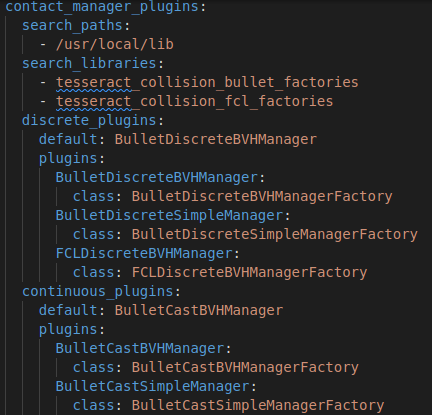
2. These checkers are derived from abstract base classes `DiscreteContactManager` and `ContinuousContactManager` for discrete and continous collisions respectively. These two abstract classes act as the API for the plugin loader. Collision tests are run using the `contactTest` function

### Bullet discrete bvh manager
#### TesseractCollisionConfiguration
1. The `TesseractCollisionConfiguration` inherits from the default `btDefaultCollisionConfiguration`. The former replaces several collision checking functions, namely `m_compoundCreateFunc`, `m_compoundCompoundCreateFunc`, `m_swappedCompoundCreateFunc` and `m_convexConvexCreateFunc`. Note that `m_compoundCreateFunc` and `m_swappedCompoundCreateFunc` are similar except for the order of the collision objects. For `m_compoundCreateFunc`, the first object is the compound collision shape while `m_swappedCompoundCreateFunc` stores the compound collision shape as the second object.
2. These functions are replaced by Tesseract algorithms that are derived classes of `btActivatingCollisionAlgorithm`

#### BulletDiscreteBVHManager
1. The manager is initialized with bullet's `dispatcher_` and `boardphase_` interfaces respectively as follows:
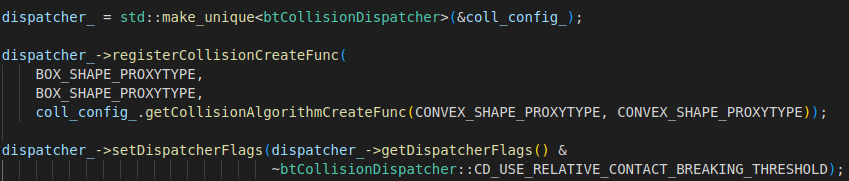
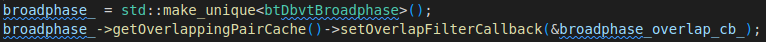

2. `dispatcher_` is initialized with the configuration object `TesseractCollisionConfiguration` that is based on `btDefaultCollisionConfiguration`. The constructor will be called to initialize with the memory reserves and algorithms specified by the configuration object. These algorithms are default algorithms as defined in `btDefaultCollisionConfiguration`. Both `m_doubleDispatchContactPoints` and `m_doubleDispatchClosestPoints` will store the collision check and the closest point algorithm respectively. Next, the default algorithm for box-box broad phase proxies to convex-convex narrow phase collision checking is updated via `dispatcher_->registerCollisionCreateFunc)`. `dispatcher_` is further customized to disable `CD_USE_RELATIVE_CONTACT_BREAKING_THRESHOLD` in order to improved performance. See comment in bullet: *//optional relative contact breaking threshold, turned on by default (use setDispatcherFlags to switch off feature for improved performance)*

3. `boardphase_` is customized to filter collision objects before the broadphase check. This is done by passing in the `broadphase_overlap_cb_` function. The function is based on `TesseractOverlapFilterCallback` that inherits from `btOverlapFilterCallback`. The `needBroadphaseCollision` function is overriden with a call to `needsCollisionCheck` where the allowable collision matrix (defined through `IsContactAllowedFn`) is used.

4. Finally, the collision margin is defaulted to 0.


#### contactTest
1. The `contactTest` function first puts the **request** and **result** into `contact_test_data_` before the collision check. `contact_test_data_.done` is used as a flag to monitor when all the contacts have been processed.
2. Next `btOverlappingPairCache* pairCache = broadphase_->getOverlappingPairCache()` gets a local pointer to the current overlapped pairs (that indicate potential collision) from the sweep and prune algorithm. This is followed by an update of the algorithm through `broadphase_->calculateOverlappingPairs(dispatcher_.get());`
3. `DiscreteBroadphaseContactResultCallback` is then created to record contact points recorded from broad phase checks. This is combined into `collisionCallback` which is an instance of `TesseractCollisionPairCallback` that inherits from `btOverlapCallback`. 
4. Taking this in, the processing of the overlapping pairs happen at `pairCache->processAllOverlappingPairs(&collisionCallback, dispatcher_.get())`

#### processAllOverlappingPairs & processCollision
1. The `pairCache` is specialized as a `btHashedOverlappingPairCache` object. The pairs are processed thorugh the `collisionCallback`'s `processOverlap` function. The processed pairs are subsequently removed.
2. The `processOverlap` function will deal with the narrow phase collisions. It first checks if the there are any pending collisions to be processed through the `results_callback_.collisions_.done` flag. Next, it will filter thorugh the allowable collision matrix to determine a collision between the two objects need further processing. This is done through the `needsCollision` function
3. Each `btBroadphasePair` will be loaded with a corresponding algorithm if it is not there yet. The algorithm will be persistent throughout the lifetime of the pair. Next, the corresponding algorithm for the given proxy pair will call `processCollision`.
4. To obtain the results from the algorithm, we use a result data struct `contactPointResult` of type `TesseractBroadphaseBridgedManifoldResult`. This data will contain a reference to the `BroadphaseContactResultCallback` passed in during the construction of `TesseractCollisionPairCallback`. The results will again be transfered to `cc` (`DiscreteBroadphaseContactResultCallback`). `cc` contains a reference of `contact_test_data_` that in turn has a reference to `collisions` (`ContactResultMap`).
5. `collisions` is the contact test results to be returned by `contactTest`

#### TesseractGjkPairDetector
1. The `TesseractGjkPairDetector` takes care of all GJK computation. The description in the file explains the possible computational improvements: 

```` This was modified to leverage the Tesseract contact request to enable and disable different parts of the algorithm. The algorithm first does a quick binary check if the two objects are in collision. If in collision it runs the penetration algorithm to get the nearest points and penetration depths. If not in collision it runs the an algorithm to get the nearest points and distance. The Tesseract contact request allow you to now decide if you need all three. Example, in the case of OMPL if you have a contact distance of zero you can get a performance increase, by disabling the penetration and distance calculation because they add no value. ````

2. The parameters highlighted in this description can be found in the definitions of `ContactRequest`
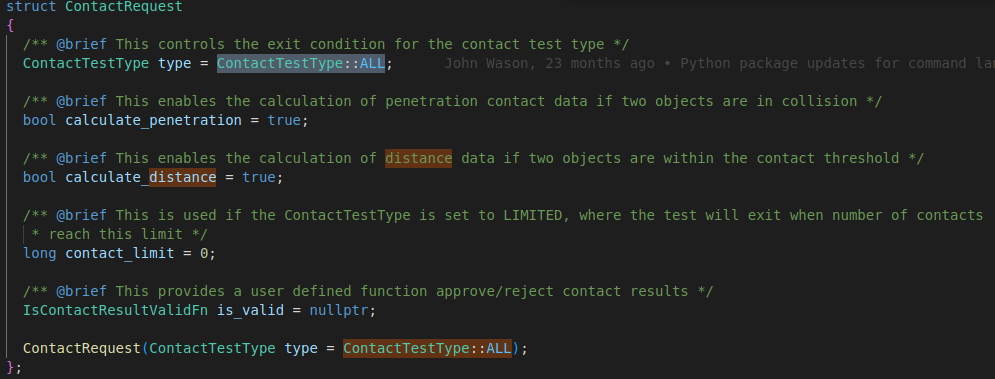

3. For sampling based planners, the `ContactTestType::FIRST` option is used while for TrajOpt, `ContactTestType::ALL` will be returned. `calculate_penetration` and `calculate_distance` are both true at initialization and remains true in the library.